## 自动驾驶之车辆探测

本次使用的探测法是YOLO探测法。要训练好一个优秀的YOLO模型是需要很多数据和计算力的，所以，本次编程中我们使用了开源的已经训练好了的YOLO模型。YOLO模型给出结果后，还需要进行剔除小概率边框和非最大值抑制，这些部分由我们自己实现

In [3]:
import numpy as np
import tensorflow as tf
import cv2
from IPython.display import Image, display
from tensorflow.keras.models import load_model
from yolo_utils import read_classes, read_anchors, yolo_head, preprocess_image, \
                        generate_colors, draw_outputs

%matplotlib inline

### 制作数据集

为了采集数据，你可以在汽车的上面安装一个照相机，然后开着车到马路上溜达溜达，照相机会每几秒拍一个照片。

<center>
<video width="600" height="300" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

采集到相片后，就需要给这些相片打上标签。如下图所示。

<center><img src="nb_images/box_label.png" style="width:500px;height:250;"></center>
<caption><center> <u> 图 1: 给图片打标签 </u></center></caption>

- p<sub>c</sub> 表示有物体的概率,1 就表示 100% 有物体，0 表示绝对没有物体
- c 表示物体的种类，是行人还是汽车...

假如要识别80种物体,第一种方法是用 1 到 80 的整数来表示不同的种类，上图中 c=3 就表示是汽车；

另一种方法是用一个有 80 个元素的向量的表示，也就是说每个元素代表一个种类，如果值是 1 就表示肯定是这个种类，如果是 0 就表示绝对不可能是这个种类。

在本次实战编程中，我们会两种方法都用，具体取决于在某个步骤时用哪个方法比较方便。

### YOLO 探测法

YOLO(you only look once)，精准度高，计算量较小，可用于实施探测

#### 细节

我们使用 Github 上一个已经训练好的 YOLO 模型，使用 yolov3

 - 模型的输入维度是 (m, 416, 416, 3)，m 是图片的个数，416 是图片像素值

 - 它会输出识别出来的物体类别以及它的边框坐标. 每个边框都对应着 6 个元素 $(p_c, b_x, b_y, b_h, b_w, c)$。当然，如果c是用一个包含80个元素的向量来表示的话，那么每个边框就对应着 85 个元素。
 
 -  yolov3 使用了 3 种不同规格的格子，分别把图片分成了 13，26，52 个格子。所以 yolov3 会输出 3 组结果。当然，格子越多就意味着格子越小，那么就能检测出更小的物体。之前 yolov2 只把图片分成了一种规格的格子，导致经常检测不出小的物体，所以 yolov3 增加了两个规格的格子来支持小物体。另外，yolov3 为每个格子安排了3种 anchor boxes。所以yolov3最终会输出3组以下维度的结果：（m,13,13,3,85)，（m,26,26,3,85)，(m,52,52,3,85)

 假设下图中的各种框框是识别出来的物体。可以看出，有不少框框是重叠的。所以我们会先去掉哪些概率小的边框，然后再使用非最大值抑制算法来去掉哪些重叠的边框。

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> 图 6 </u><br> </center></caption>

In [174]:
# 过滤掉概率低的边框

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.6, debug=False):
    '''
    参数：
    box_confidence -- 装载着每一个边框的 Pc
    boxes -- 装载着每个边框的坐标
    box_class_probs -- 装载着每个边框的 80 个种类的概率
    threshold -- 阈值，概率低于这个值的边框会被过滤掉

    返回值：
    scores -- 装载保留下的那些边框的概率
    boxes -- 装载保留下的那些边框的坐标
    classes -- 装载保留下的那些边框的种类的索引
    '''

    # 将 Pc 和 c 相乘，得到具体每个种类是否存在的概率
    box_scores = box_confidence * box_class_probs
    debug and print('box_scores.shape:', box_scores.shape)

    # 获取概率最大的那个种类的索引
    box_classes = tf.argmax(box_scores, axis=-1)
    debug and print('box_classes.shape:', box_classes.shape)

    # 获取概率最大的那个种类的概率值
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    debug and print('box_class_scores.shape:', box_class_scores.shape)

    # 创建一个过滤器，当某个种类的概率值大于等于阈值 threshold 时
    # 对应与这种种类的 filtering_mask 中的位置就是 true，否则就是 false
    # 所以 filtering_mask 就是 [False, True, ..., True, False] 这种形式
    filtering_mask = tf.greater_equal(box_class_scores, threshold)
    debug and print('filtering_mask.shape:', filtering_mask.shape)

    # 用上面的过滤器来过滤掉那些概率小的边框
    # 过滤完成后，scores、boxes 和 classes 里面就只装载了概率大的边框的概率值和坐标以及种类索引
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [175]:
# unit test

box_confidence = tf.random.normal([13, 13, 3, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([13, 13, 3, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([13, 13, 3, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5, debug=True)
print("-----")
print("scores[2] = ",scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = " , classes[2])
print("scores.shape = " , scores.shape)
print("boxes.shape = " , boxes.shape)
print("classes.shape = " , classes.shape)

box_scores.shape: (13, 13, 3, 80)
box_classes.shape: (13, 13, 3)
box_class_scores.shape: (13, 13, 3)
filtering_mask.shape: (13, 13, 3)
-----
scores[2] =  tf.Tensor(24.299408, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([ 2.725436   3.4908202 -2.3398066 -1.4686031], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(73, shape=(), dtype=int64)
scores.shape =  (502,)
boxes.shape =  (502, 4)
classes.shape =  (502,)


#### 非最大值抑制 Non-max suppression

上面我们使用阈值过滤掉了一些小概率的边框，但是依然有很多重叠的边框。这一步我们将使用非最大值抑制 Non-max suppression(NMS)技术来过滤掉那些重叠的边框。

<img src="nb_images/non-max-suppression.png" style="width:850px;height:400px;">
<caption><center> <u> 图 7 </u> </center></caption>

左图中3个边框预测的其实都是同一辆车，通过NMS后，去掉重叠的边框，只保留概率值最大的那个，得到右图

NMS的主要步骤如下

1. 找到概率值最高的一个边框

2. 找到与这个边框高度重叠的其它边框，也就是交并比很高的其它边框，然后过滤掉它们。当然，交并比到底多高才过滤掉呢？为此我们会给定一个阈值 `iou_threshold`.

3. 重复进行上面两步

In [182]:
# 用非最大值抑制技术过滤掉重叠的边框

def yolo_non_max_suppression(scores, boxes, classes, max_boxes=20, iou_threshold=0.5, debug=False):
    '''
    参数：
    scores -- 前面 yolo_filter_boxes 函数保留下的边框的概率值
    boxes -- 前面 yolo_filter_boxes 函数保留下的边框的坐标
    classes -- 前面 yolo_filter_boxes 函数保留下的边框的种类的索引
    max_boxes -- 最多想要保留多少个边框
    iou_threshold -- 交并比，大于这个阈值的边框才会被进行非最大值抑制处理

    Returns:
    scores -- NMS 保留下的边框的概率值
    boxes -- NMS 保留下的边框的坐标
    classes -- NMS 保留下的边框的种类的索引
    '''

    # tensorflow 为我们提供了一个 NMS 函数，可以直接调用
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold=iou_threshold)
    debug and print('nms_indices.shape =', nms_indices.shape)

    # 通过上面的索引来分别获取被保留的边框的相关概率值、坐标以及种类的索引
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)

    return scores, boxes, classes

In [183]:
# unit test
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, debug=True)
print("scores[2] = ", scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = " , classes[2])
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = " , classes.shape)

nms_indices.shape = (20,)
scores[2] =  tf.Tensor(5.558397, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([ 6.0916195  -0.97332215 -9.200445   -3.7347412 ], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(4.2351055, shape=(), dtype=float32)
scores.shape =  (20,)
boxes.shape =  (20, 4)
classes.shape =  (20,)


In [184]:
# 最终过滤函数
# 整合了前面的两个过滤函数，将 YOLO 函数的输出结果输入到这个函数后，这个函数会将多余的边框过滤掉

def yolo_eval(outputs, max_boxes=20, score_threshold=.5, iou_threshold=.5):
    '''
    参数：
    outputs -- YOLO 模型的输出结果
    max_boxes -- 最多识别出多少边框
    score_threshold -- 概率值阈值
    iou_threshold -- 交并比阈值

    Returns:
    scores -- 最终留下的边框的概率值
    boxes -- 最终留下的边框的坐标
    classes -- 最终留下的边框的种类的索引
    '''

    # 建立三个空的 list
    s, b, c = [], [], []

    # 我们调用 Yolov3 使用了 3 个规格的网格 (13*13, 26*26, 52*52)，因此有三组 output
    for output in outputs:
        # 将 YOLO 输出结果分成三份，表示概率值、坐标和种类索引
        box_confidence, boxes, box_class_probs = output

        # 使用我们前面实现的 yolo_filter_boxes 函数过滤掉概率值低于阈值的边框
        scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs,
                                                    threshold=score_threshold)

        s.append(scores)
        b.append(boxes)
        c.append(classes)
    
    # 整合 3 组 output 的结果
    scores = tf.concat(s, axis=0)
    boxes = tf.concat(b, axis=0)
    classes = tf.concat(c, axis=0)

    # 使用我们实现的 yolo_non_max_suppression 过滤掉重叠的边框
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, 
                                                        max_boxes=max_boxes,
                                                        iou_threshold=iou_threshold)

    return scores, boxes, classes

In [185]:
# unit test
yolo_output = (tf.random.normal([13, 13, 3, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([13, 13, 3, 4], mean=1, stddev=4, seed = 1),
                tf.random.normal([13, 13, 3, 80], mean=1, stddev=4, seed = 1))
yolo_output1 = (tf.random.normal([26, 26, 3, 1], mean=1, stddev=4, seed = 2),
                tf.random.normal([26, 26, 3, 4], mean=1, stddev=4, seed = 2),
                tf.random.normal([26, 26, 3, 80], mean=1, stddev=4, seed = 2))
yolo_output2 = (tf.random.normal([52, 52, 3, 1], mean=1, stddev=4, seed = 3),
                tf.random.normal([52, 52, 3, 4], mean=1, stddev=4, seed = 3),
                tf.random.normal([52, 52, 3, 80], mean=1, stddev=4, seed = 3))
yolo_outputs = (yolo_output, yolo_output1, yolo_output2)
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = ", scores[2])
print("boxes[2] = " , boxes[2])
print("classes[2] = ", classes[2])
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = " , classes.shape)

scores[2] =  tf.Tensor(183.36862, shape=(), dtype=float32)
boxes[2] =  tf.Tensor([-0.9321569  1.2601769 -0.5666194 -1.3579395], shape=(4,), dtype=float32)
classes[2] =  tf.Tensor(23, shape=(), dtype=int64)
scores.shape =  (20,)
boxes.shape =  (20, 4)
classes.shape =  (20,)


### 使用 YOLO 模型进行车辆探测

#### 定义种类以及 anchor box 和像素


In [192]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

#### 加载已经训练好的 YOLO 模型

如果加载出现故障，运行 yolov3-tf2/'model by myself-Copy1.ipynb' 重新生成模型

In [211]:
yolo_model = load_model('model_data/yolo_model.h5')

In [212]:
yolo_model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 yolo_darknet (Functional)      [(None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

In [213]:
# 探测图片
img_raw, img = preprocess_image('test.jpg', model_image_size=(416, 416))
yolo_outputs = yolo_model(img)

In [215]:
# 将 YOLO 模型的输出转换成我们需要的格式
outputs = yolo_head(yolo_outputs, anchors, len(class_names))

In [216]:
# 过滤边框
out_scores, out_boxes, out_classes = yolo_eval(outputs)

In [217]:
# 将检测到的 boxes 在图片中显示出来
def img_show(image_file, out_scores, out_boxes, out_classes, class_names):
    img_raw = tf.image.decode_image(open('./images/'+image_file, 'rb').read(), channels=3)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    colors = generate_colors(class_names)
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    img = draw_outputs(img, out_scores, out_boxes, out_classes, colors, class_names)
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    file_name = [x for x in image_file.split('.')]
    cv2.imwrite('./out/'+file_name[0]+'_out.'+file_name[1], img)
    return img

Found 13 boxes for test.jpg
car 1.00 (353, 295) (755, 645)
car 1.00 (761, 286) (924, 405)
car 1.00 (943, 321) (1289, 701)
car 0.99 (925, 294) (1054, 380)
car 0.99 (142, 304) (330, 448)
car 0.91 (709, 282) (778, 347)
car 0.87 (309, 304) (366, 355)
car 0.77 (384, 292) (437, 325)
car 0.75 (674, 279) (720, 321)
car 0.75 (328, 300) (376, 350)
car 0.71 (965, 272) (1025, 290)
traffic light 0.70 (680, 194) (690, 210)
truck 0.62 (579, 247) (644, 298)


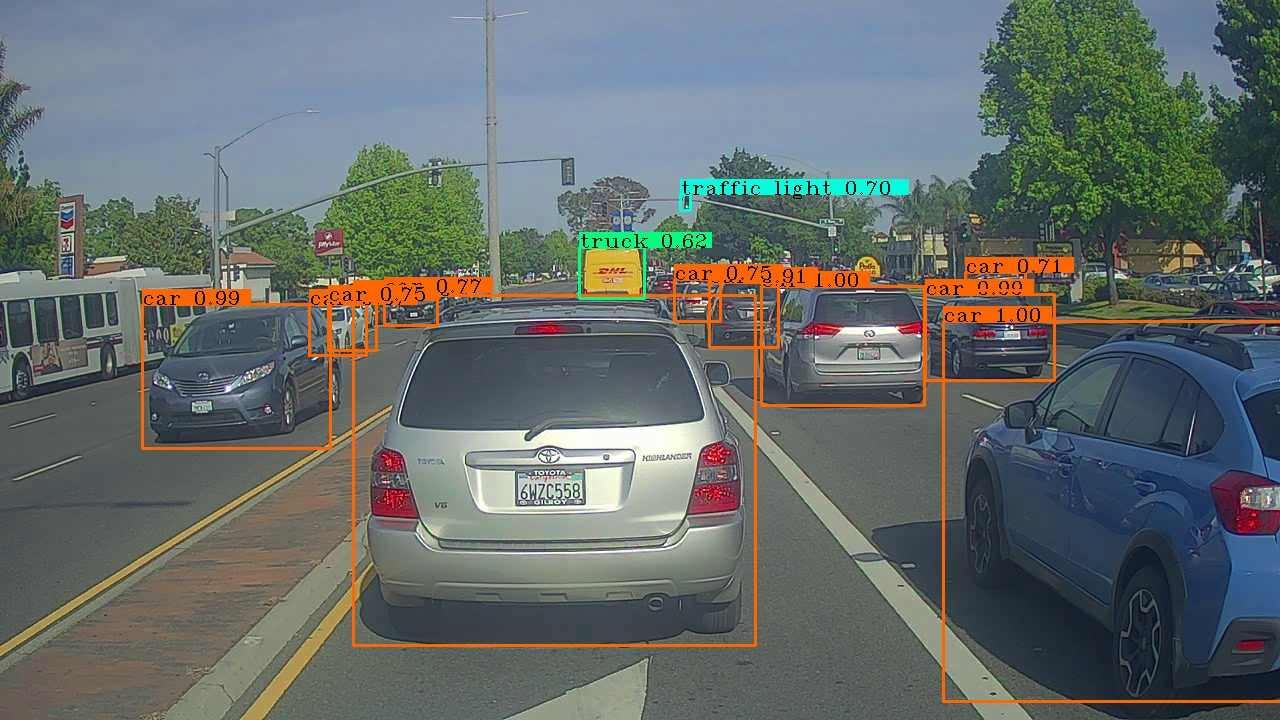

In [218]:
img = img_show('test.jpg', out_scores, out_boxes, out_classes, class_names)

### 将上面所有的函数结合起来

In [219]:
def predict(model, image_file, anchors, class_names):
    img_raw, img = preprocess_image(image_file, model_image_size = (416, 416))
    yolo_outputs = yolo_model(img)
    outputs = yolo_head(yolo_outputs, anchors, len(class_names))
    out_scores, out_boxes, out_classes = yolo_eval(outputs)
    img = img_show(image_file, out_scores, out_boxes, out_classes, class_names)
    return img

Found 20 boxes for test2.jpg
car 1.00 (218, 384) (405, 562)
car 1.00 (374, 379) (469, 520)
car 0.99 (715, 301) (856, 442)
car 0.99 (369, 234) (467, 309)
car 0.99 (253, 262) (412, 392)
car 0.99 (25, 312) (253, 496)
bus 0.98 (692, 102) (835, 264)
car 0.97 (237, 75) (282, 129)
car 0.97 (64, 502) (305, 561)
car 0.96 (377, 165) (464, 239)
car 0.96 (378, 350) (513, 468)
car 0.96 (419, 308) (552, 447)
car 0.95 (504, 152) (599, 212)
bus 0.93 (8, 12) (154, 149)
car 0.92 (527, 254) (625, 387)
car 0.91 (640, 130) (695, 204)
truck 0.91 (455, 18) (540, 116)
car 0.91 (566, 125) (630, 183)
car 0.89 (4, 180) (83, 270)
car 0.88 (494, 105) (573, 174)


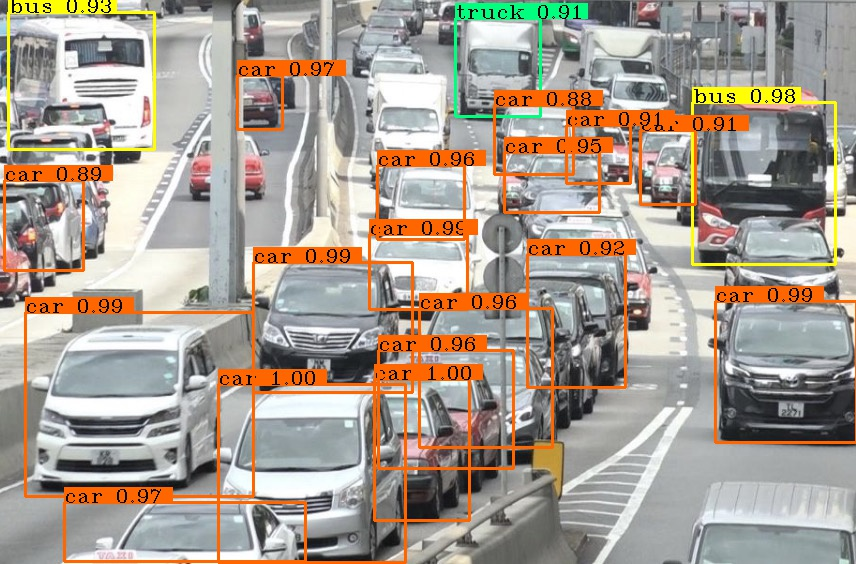

In [220]:
img = predict(yolo_model, 'test2.jpg', anchors, class_names)